{% include toc title = "In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* Learn how to process a `JSON` file with twitter data in Python

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson.

</div>

## Process a JSON File with Twitter Data in Python

In the previous lessons, you accessed twitter data using the Twitter API and Tweepy.
In this lesson you will process a json file that contains twitter data in it.
This will give you experience with using complex JSON files in Open Source Python.

As always, you need to load a suite of libraries first.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import json
import tweepy as tw
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
from textblob import TextBlob
import networkx
import networkx as nx
import earthpy as et

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Get the already collected twitter data in JSON format
et.data.get_data('twitter-flood')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

The data in this lesson were collected during the 2013 Colorado Flood event. 
To begin, you create a path to open the data.

In [2]:
flood_tweets_path = os.path.join("twitter-flood", 
                                 "boulder_flood_geolocated_tweets.json")
flood_tweets_path

'twitter-flood/boulder_flood_geolocated_tweets.json'

Next, you open the json file. You will have to create a for loop given the size
and complexity of the file. This loop will iterate through each tweet and add
it to a list. You can then use that list to process your data. 

In [3]:
# Loop through each tweet in the JSON file and append it to a list
flood_tweets = []
for line in open(flood_tweets_path, 'r'):
    flood_tweets.append(json.loads(line))

# View a single tweet in your list.
flood_tweets[1]

{'created_at': 'Tue Dec 31 18:49:31 +0000 2013',
 'id': 418091565161017345,
 'id_str': '418091565161017345',
 'text': '@WeatherDude17 Not that revved up yet due to model inconsistency. I\'d say 0-2" w/ a decent chance of &gt;1" #snow #COwx #weather #Denver',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'snow', 'indices': [108, 113]},
   {'text': 'COwx', 'indices': [114, 119]},
   {'text': 'weather', 'indices': [120, 128]},
   {'text': 'Denver', 'indices': [129, 136]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'WeatherDude17',
    'name': 'WeatherDude',
    'id': 1214463582,
    'id_str': '1214463582',
    'indices': [0, 14]}],
  'urls': []},
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
 'in_reply_to_status_id': 418091408994471937,
 'in_reply_to_status_id_str': '418091408994471937',
 'in_reply_to_user_id': 1214463582,
 'in_reply_to_user_id_str': '1214463582',
 'in_reply_to_screen_name': 'WeatherDude17',
 'user'

## Json Stored as Python Dictionaries

The data extracted from your json file are returned in Python as a dictionary. 

In [4]:
type(flood_tweets[1])

dict

A dictionary is a hierarchical Python data a format that allows you to store
nested information. You can access elements of the dictionary using keys 

In [5]:
a_single_tweet = flood_tweets[1]
a_single_tweet.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

You can access a single key using the `["key-here"]` syntax.

In [6]:
# View the created at time stamp in the dictionary
a_single_tweet["created_at"]

'Tue Dec 31 18:49:31 +0000 2013'

Nested keys can be accessed with multiple square brackets. 
Above you select the hashtags from the tweet. Notice that the indices or 
locations of the hashtag within the tweet text are included with this dictionary
element. Also notice that you can access each index individually if you want.

In [7]:
a_single_tweet["entities"]["hashtags"]

[{'text': 'snow', 'indices': [108, 113]},
 {'text': 'COwx', 'indices': [114, 119]},
 {'text': 'weather', 'indices': [120, 128]},
 {'text': 'Denver', 'indices': [129, 136]}]

In [8]:
# Get the second item in the list and it's associated hashtag
a_single_tweet["entities"]["hashtags"][1]["text"]

'COwx'

## Text Parsing of Twitter Data

Using what you have learned in the previous lessons, you will clean up the 
data by:

1. removing URL's
2. removing stop words and
3. removing additional words that may be throwing off your word counts

To begin remove url's from your tweets. 

In [9]:
# https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d

In [10]:
def remove_url_punctuation(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)
    
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', no_url)
    
    # Clean up punctuation (including pound signs)
    return no_punct

In [11]:
# Create a custom search term and define the number of tweets
flood_tweets[2]["text"]

'Story of my life! 😂 #boulder http://t.co/ZMfNKEl0xD'

In [12]:
# Remove URLs
tweets_no_urls = [remove_url_punctuation(atweet["text"]) for atweet in flood_tweets]
tweets_no_urls[2]

'Story of my life  boulder '

In [13]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]
words_in_tweet[2]

['story', 'of', 'my', 'life', 'boulder']

In [14]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Count each word across all tweets - notice there are still stop words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('rt', 7884),
 ('boulder', 6980),
 ('the', 6849),
 ('in', 5730),
 ('to', 5619),
 ('cowx', 5338),
 ('boulderflood', 5317),
 ('of', 4778),
 ('coflood', 4312),
 ('a', 3240),
 ('for', 3156),
 ('and', 2823),
 ('is', 2596),
 ('at', 2330),
 ('on', 2282)]

In [15]:
# Remove stop words and any other words you want to clean up
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection and other twitter related words (rt = retweet on twitter)
collection_words = ['rt']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

tweets_nsw_nc[2]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leahwasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['story', 'life', 'boulder']

In [16]:
# Process for word counts
all_words_nsw = list(itertools.chain(*tweets_nsw_nc))

counts_nsw = collections.Counter(all_words_nsw)

clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
clean_tweets_nsw

,words,count
0,boulder,6980
1,cowx,5338
2,boulderflood,5317
3,coflood,4312
4,colorado,2237
5,denver,1480
6,flood,1285
7,snow,1202
8,amp,1202
9,weather,1070


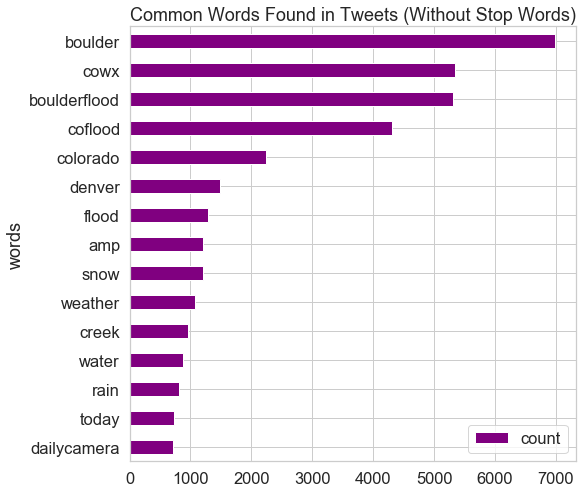

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

## Collection of Words -- Bigrams

In [18]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# Flatten list of bigrams in clean tweets
coupled_words = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(coupled_words)

bigram_counts.most_common(20)

[(('cowx', 'weather'), 618),
 (('boulder', 'colorado'), 457),
 (('boulder', 'creek'), 436),
 (('cowx', 'coflood'), 408),
 (('boulderflood', 'cowx'), 287),
 (('boulder', 'county'), 268),
 (('boulderflood', 'coflood'), 256),
 (('cowx', 'gjco'), 214),
 (('boulder', 'boulderflood'), 199),
 (('cowx', 'westernslope'), 192),
 (('cowx', 'denver'), 189),
 (('flash', 'flood'), 188),
 (('boulder', 'canyon'), 185),
 (('coflood', 'cowx'), 181),
 (('wall', 'water'), 179),
 (('coflood', 'boulderflood'), 164),
 (('higher', 'ground'), 163),
 (('dailycamera', 'boulder'), 156),
 (('flood', 'warning'), 149),
 (('boulder', 'co'), 144)]

In [19]:

# Create a network plot of grouped terms
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


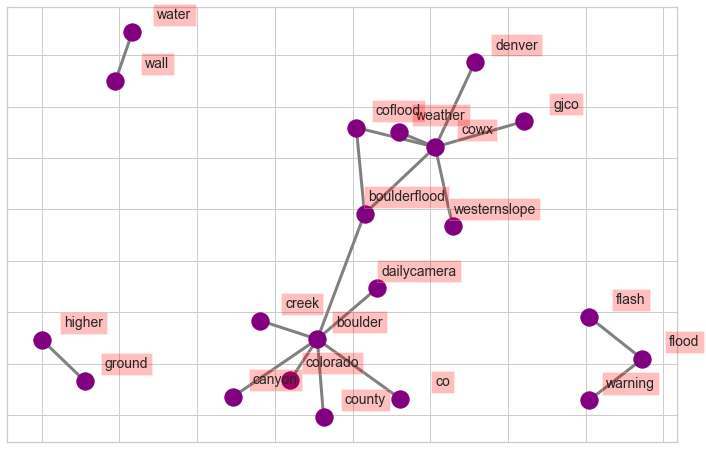

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G, k=5.5)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.05
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=14)
    
plt.show()

## Analyze Sentiments in Tweets

You can use the `Python` package `textblob` to calculate the polarity 
values of individual tweets. For this analysis you may want to include
emojiis as they represent sentiment. This step has not been included 
below.

Begin by creating `textblob` objects, which assigns polarity values 
to the tweets. You can identify the polarity value using the attribute 
`.polarity` of `texblob` object.

In [21]:
# Create textblob objects of the tweets
sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]

sentiment_objects[0].polarity, sentiment_objects[2]

(-0.5, TextBlob("Story of my life  boulder "))

You can apply list comprehension to create a list of the polarity values and text for each tweet, and then create a `Pandas Dataframe` from the list. 

In [22]:
# Create list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[2:8]

[[0.0, 'Story of my life  boulder '],
 [0.0,
  'Were looking for the two who came to help a cyclist after a hitandrun at 30thBaseline 11pm Dec 23rd Boulder CO '],
 [0.3575757575757576,
  'Happy New Year Boulder  What are some of your New Years resolutions this year'],
 [0.34545454545454546,
  'simon_Says_so Nearly 60 degrees in Boulder today Great place to live '],
 [0.0, 'Deer boulder onlyinboulder '],
 [0.0,
  'NWS has only bumped up tomrorows odds for snow in Denver from 30 to 40 To me it feels like it should be closer to 60 COwx weather']]

In [23]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.tail()

,polarity,tweet
18816,0.000,RT EricRobertson A more representative flood p...
18817,0.125,Warning Flash flood of boulder creek is immine...
18818,0.550,I just got an Emergency Alert Nice to know the...
18819,0.000,RT dailycamera RT CUBoulderPolice Some floodi...
18820,0.000,monikarun courtneyo eatplaylove Greeblemonkey ...


These polarity values can be plotted in a histogram, which can help to highlight in the overall sentiment (i.e. more positivity or negativity) toward the subject. 

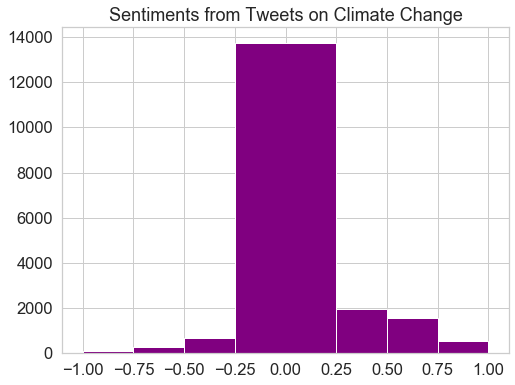

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

To better understand the distribution of positive vs negative sentiment, 
you can remove the polarity values that are equal to 0. 

In [25]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

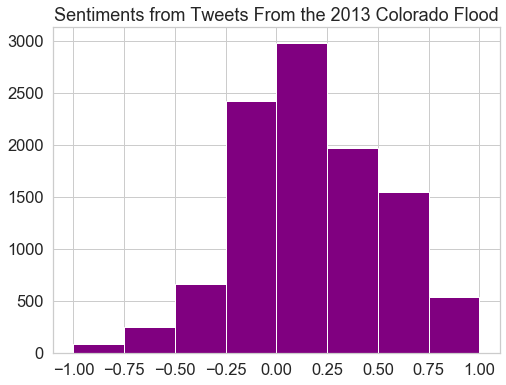

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets From the 2013 Colorado Flood")
plt.show()

What does the histogram of the polarity values tell you about sentiments in the tweets gathered from the search "#climate+change -filter:retweets"? Are they more positive or negative?

### Get and Analyze Tweets Related to the Camp Fire

Next, explore a new topic, the 2018 Camp Fire in California. 

Begin by searching for the tweets and combining the cleaning of the data (i.e. removing URLs) with the creation of the `textblob` objects. 

Based on this histogram, would you say that the sentiments from the Camp Fire tweets are more positive or negative?